In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.cluster import KMeans
from scipy import stats
from nltk.corpus import stopwords

### Read in Data

In [2]:
df = pd.read_csv("/Users/gabrieltaylor/Python/STAT542/en.openfoodfacts.org.products.tsv", sep = "\t")

/Users/gabrieltaylor/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot Missing Values

In [4]:
miss_vals = pd.DataFrame(df.isna().mean()).reset_index()
miss_vals.columns = ["Columns", "MV Rate"]
miss_vals = miss_vals.sort_values("MV Rate")

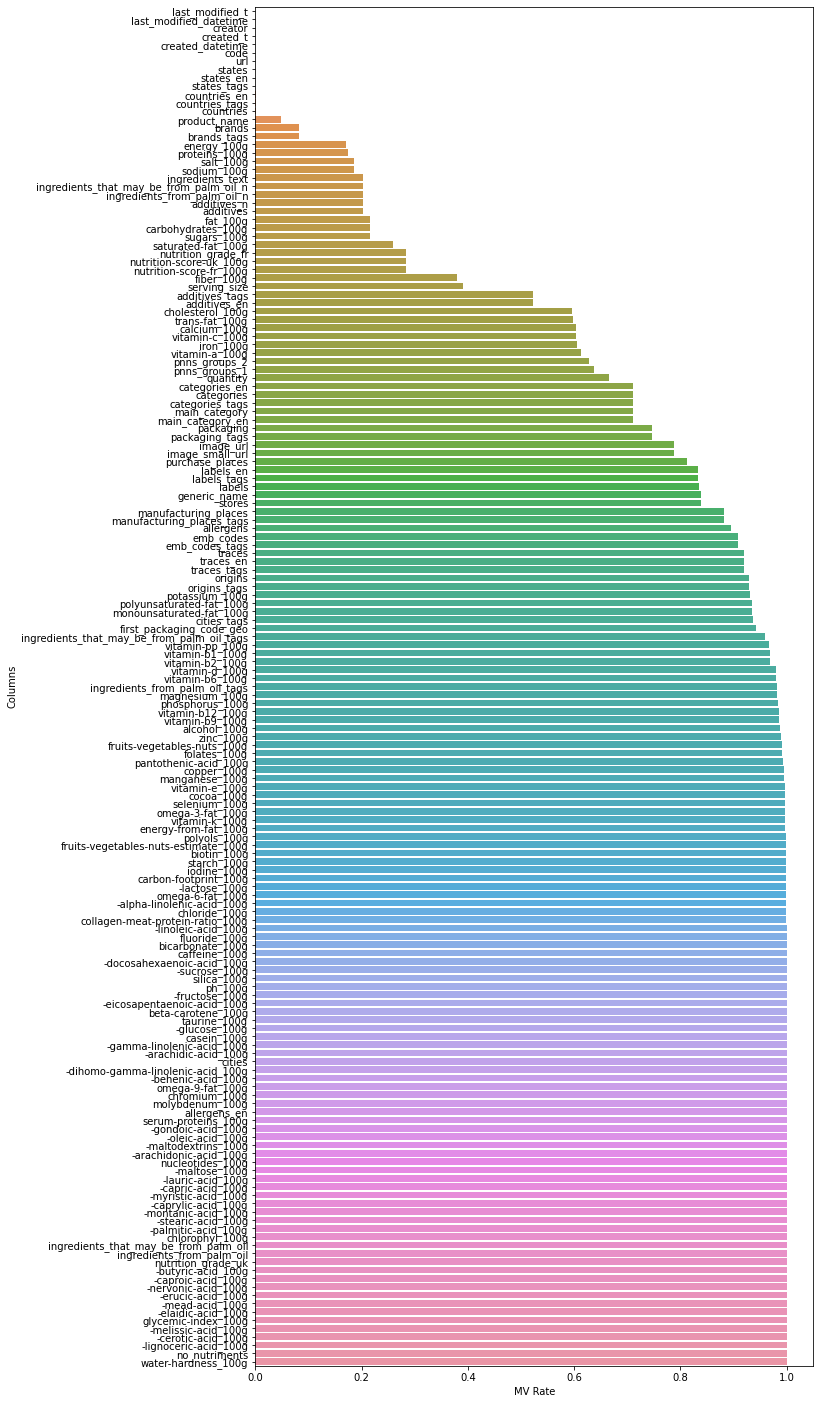

In [88]:
plt.figure(figsize = (10, 25))
sns.barplot("MV Rate", "Columns", data = miss_vals, orient = "h")

### Remove Columns above 30% Missing Values

In [5]:
keep_cols = miss_vals[miss_vals["MV Rate"] < 0.3]["Columns"]

In [6]:
df2 = df[keep_cols]

### Remove General Information 

In [7]:
rm_cols = [ 'last_modified_t',
            'last_modified_datetime',
             'creator',
             'created_t',
             'created_datetime',
             'code',
             'url',
             'states',
             'states_en',
             'states_tags',
             'countries_tags',
             'countries',
             'ingredients_that_may_be_from_palm_oil_n',
             'ingredients_from_palm_oil_n',
             'product_name', ### Perhaps Keep
             'brands', ### Perhaps Keep
             'brands_tags',
             'additives', ### contained in ingredients
             'additives_n',
             'nutrition-score-uk_100g', ### Related to target
             'nutrition_grade_fr', ### Related to target
             'salt_100g' ### Sodium will suffice
          ]

In [8]:
df3 = df2.drop(rm_cols, axis = 1)

## Check Missingness

In [9]:
pd.DataFrame(df3.isna().mean()).reset_index()

,index,0
0,countries_en,0.000772
1,energy_100g,0.170380
2,proteins_100g,0.173768
3,sodium_100g,0.186315
4,ingredients_text,0.202608
5,fat_100g,0.214956
6,carbohydrates_100g,0.215734
7,sugars_100g,0.215829
8,saturated-fat_100g,0.258980
9,nutrition-score-fr_100g,0.284167


### Remove All Missing Rows For Right Now

In [10]:
df4 = df3.dropna()

In [11]:
df4.shape[0] / df3.shape[0]

0.6426394627373767

# Unsupervised Task

In [ ]:
def scale(x):
    return (x - np.mean(x)) / np.std(x)

## Clustering Macronutrients

In [347]:
keep_cols = ['ingredients_text',
             'carbohydrates_100g',
             'fiber_100g',
             'sugars_100g',
             'proteins_100g', 
             'fat_100g', 
             'saturated-fat_100g']
clust_df = df[keep_cols]
clust_df = clust_df.dropna()

In [348]:
clean_ingre = lambda s: " ".join( map( lambda s1: s1.strip().replace(" ", "-") , s.lower().replace(".","").replace("(",",").replace(")",",").split(",") ) )

In [349]:
clust_df["ingredients_text"] = [clean_ingre(i) for i in clust_df["ingredients_text"]]

### Keep Only Rows With The Most Common Ingredients

Rows containing ingredients that are **not** in the the most common words list are dropped

In [350]:
all_words = [i for ing in clust_df['ingredients_text'] for i in ing.split()]

In [351]:
most_common_words = dict(Counter(all_words).most_common(1000))

In [352]:
clust_df = clust_df[[all(i in most_common_words.keys() for i in i_list.split()) for i_list in clust_df['ingredients_text']]]

In [353]:
clust_df.head()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
2,peanuts wheat-flour sugar rice-flour tapioca-s...,60.71,7.1,17.86,17.86,17.86,0.00
30,organic-coconut,53.33,6.7,6.67,6.67,30.00,26.67
38,organic-coconut,24.00,16.0,7.00,6.00,65.00,57.00
148,cranberries sugar sunflower-oil,83.33,10.0,66.67,0.00,0.00,0.00
149,apricots sulfur-dioxide,62.50,7.5,52.50,2.50,0.00,0.00


### Remove outliers

In [354]:
clust_df = clust_df[(np.abs(stats.zscore(clust_df.drop(["ingredients_text"], axis = 1))) < 3).all(axis = 1)]

In [355]:
clust_df.describe()

,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
count,12277.000000,12277.000000,12277.000000,12277.000000,12277.00000,12277.000000
mean,28.127085,2.700839,11.176865,9.885555,15.22132,4.956619
std,29.103303,3.504133,18.002026,9.279081,19.13315,7.077012
min,0.000000,0.000000,-1.200000,0.000000,0.00000,0.000000
25%,3.700000,0.000000,0.000000,1.600000,0.00000,0.000000
50%,14.290000,1.600000,3.570000,7.000000,3.33000,0.340000
75%,56.250000,3.600000,10.620000,17.650000,28.57000,7.140000
max,100.000000,18.000000,73.330000,38.460000,82.14000,30.000000


### Center and Scale

In [356]:
for col in keep_cols[1:]:
    clust_df[col] = scale(np.array(clust_df[col]))

In [357]:
clust_df.describe()

,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
count,1.227700e+04,1.227700e+04,1.227700e+04,1.227700e+04,1.227700e+04,1.227700e+04
mean,1.111218e-16,-4.167067e-17,9.260148e-17,4.282818e-17,3.935563e-17,1.574225e-16
std,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00
min,-9.664962e-01,-7.707895e-01,-6.875542e-01,-1.065403e+00,-7.955794e-01,-7.004115e-01
25%,-8.393577e-01,-7.707895e-01,-6.208924e-01,-8.929648e-01,-7.955794e-01,-7.004115e-01
50%,-4.754666e-01,-3.141672e-01,-4.225733e-01,-3.109869e-01,-6.215288e-01,-6.523667e-01
75%,9.663529e-01,2.566106e-01,-3.093475e-02,8.368028e-01,6.977013e-01,3.085299e-01
max,2.469680e+00,4.366211e+00,3.452704e+00,3.079573e+00,3.497668e+00,3.538838e+00


### Kmeans

In [358]:
n_clust = 7

In [359]:
X = np.array(clust_df.drop(["ingredients_text"], axis = 1))
kmeans = KMeans(n_clusters = n_clust, random_state = 69).fit(X)

### Macro Profile of Clusters

In [360]:
clust_df['clust'] = kmeans.labels_

In [361]:
clust_df.groupby('clust').mean()

,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
clust,,,,,,
0,0.968331,0.271129,1.722463,-0.387930,0.812877,1.597583
1,1.631109,-0.062948,2.498615,-0.684789,-0.624892,-0.574979
2,1.427541,0.405686,-0.381313,0.043734,-0.455033,-0.561999
3,-0.213825,1.842528,-0.364679,0.916062,1.956182,0.147548
4,-0.875904,-0.756694,-0.584285,1.359728,0.771878,1.697450
5,-0.575626,-0.355994,-0.248121,-0.870631,-0.692513,-0.603841
6,-0.881210,-0.734198,-0.543491,0.957949,-0.426027,-0.368349


In [362]:
clust_df.groupby('clust').count()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g
clust,,,,,,,
0,757,757,757,757,757,757,757
1,1044,1044,1044,1044,1044,1044,1044
2,1945,1945,1945,1945,1945,1945,1945
3,1449,1449,1449,1449,1449,1449,1449
4,1889,1889,1889,1889,1889,1889,1889
5,4346,4346,4346,4346,4346,4346,4346
6,847,847,847,847,847,847,847


### Most Common Ingredients For Each Cluster

In [363]:
rm_words = set(stopwords.words('english') + ['de', 'contains', 's', 'et', 'of', 'en', "fr",'less', 'p', 'exists', 'following', 'ok'])
better_words = rm_words
[better_words.add(i) for i in ['water', 'sea-salt', 'sugar', 'salt', 'sel', 'eau']]

[None, None, None, None, None, None]

In [364]:
all_words = [i for ing in clust_df['ingredients_text'] for i in ing.split()]

In [365]:
tot_word_counts = dict(Counter(all_words))

In [366]:
### TD IDF
N = clust_df.shape[0]

### WE USE TD-IDF TO DEFINE WORD PREVELANCE BY CLUSTER 

In [367]:
def clust_word_prevelance(col):
    
    ### All Words For Cluster
    all_words = [i for ing in col for i in ing.split()]
    
    ### Stop Words
    reduced_words = [w for w in all_words if w not in better_words]
    
    ### Count Words
    clust_word_counts = dict(Counter(reduced_words).most_common())
    
    ### TF IDF To Obtain True Cluster Prevelance 
    for key in clust_word_counts.keys():
        clust_word_counts[key] = clust_word_counts[key] * np.log(N / tot_word_counts[key])
    
    return clust_word_counts

In [368]:
clust_words = clust_df.groupby('clust')['ingredients_text'].apply(clust_word_prevelance)

## Let's Plot It Shall We

                  ingredients_text
cocoa-butter           1340.120845
soy-lecithin           1083.036709
chocolate-liquor        969.411954
vanilla                 827.088033
butter                  657.840629


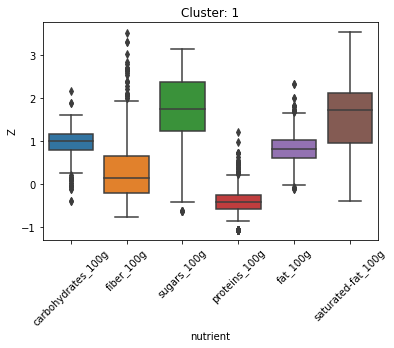

                                ingredients_text
corn-syrup                           1084.203185
red-40                                845.653328
yellow-5                              796.834434
natural-and-artificial-flavors        735.215657
gelatin                               712.670607


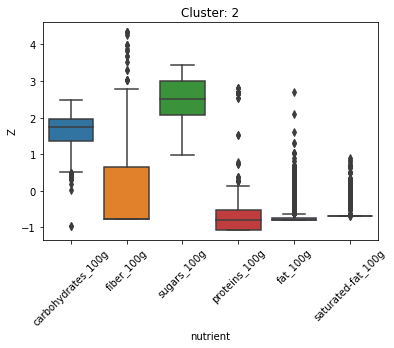

                 ingredients_text
niacin                2013.105343
riboflavin            1983.935863
folic-acid            1956.303251
iron                  1677.868142
ferrous-sulfate       1609.420794


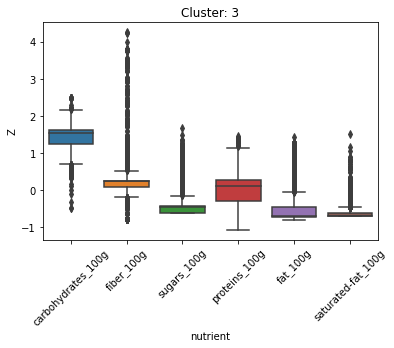

            ingredients_text
almonds          1340.068469
peanuts          1004.812435
peanut-oil        858.706212
pecans            849.084381
walnuts           741.622681


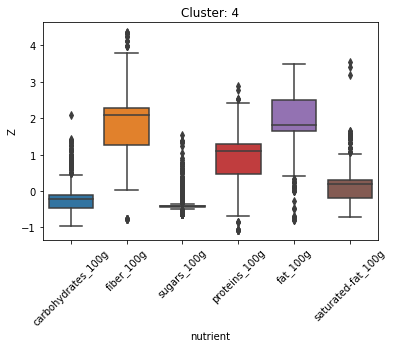

                            ingredients_text
enzymes                          2766.488258
pasteurized-milk                 2124.208136
cheese-culture                   1964.597206
cheese-cultures                  1140.887836
pasteurized-part-skim-milk       1072.304013


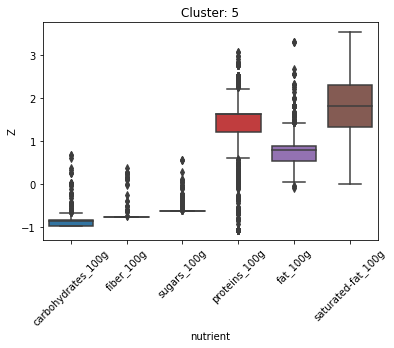

               ingredients_text
citric-acid         1693.304957
green-beans         1191.414808
ascorbic-acid       1156.546455
tomatoes            1109.536551
vitamin-d3          1089.547548


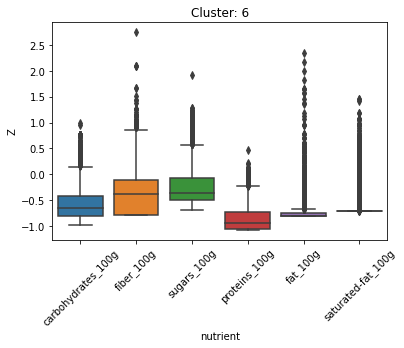

                         ingredients_text
shrimp                        1085.769701
sodium-tripolyphosphate        772.736200
to-retain-moisture             686.759430
sodium-nitrite                 616.064196
sodium-erythorbate             577.433573


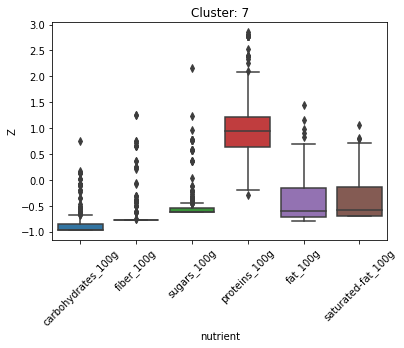

In [369]:
for c in range(n_clust):
    print(pd.DataFrame(clust_words[c]).dropna().sort_values('ingredients_text', ascending = False).iloc[:5, ])
    
    temp_df = clust_df[clust_df.clust == c]
    plot_df = pd.DataFrame(temp_df.drop(['clust', 'ingredients_text'], axis = 1).stack()).reset_index()
    plot_df.columns = ['fuck this column', 'nutrient', 'val']
    sns.boxplot(x = 'nutrient', y = 'val', data = plot_df)
    plt.title("Cluster: " + str(c + 1))
    plt.ylabel("Z")
    plt.xticks(rotation = 45)
    plt.show()

## Validate Results With Food Category

In [370]:
clust_df2 = clust_df.join(df['categories_en'])
clust_df2.head()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g,clust,categories_en
2,peanuts wheat-flour sugar rice-flour tapioca-s...,1.119606,1.255472,0.371259,0.859435,0.137917,-0.700412,2,NaN
30,organic-coconut,0.866017,1.141316,-0.250363,-0.346552,0.772444,3.068281,0,NaN
148,cranberries sugar sunflower-oil,1.896869,2.083100,3.082730,-1.065403,-0.795579,-0.700412,1,NaN
149,apricots sulfur-dioxide,1.181114,1.369627,2.295565,-0.795968,-0.795579,-0.700412,1,NaN
171,almonds,-0.279261,3.024883,-0.435906,1.090071,1.817792,-0.229855,3,NaN


In [371]:
clust_df2['categories_en'] = clust_df2['categories_en'].fillna('Missing')
clust_df2['categories_en'] = [re.sub(",", " ", s) for s in clust_df2['categories_en']]
clust_df2['categories_en'] = [s.split()[0] for s in clust_df2['categories_en']]
dict(clust_df2['categories_en'].value_counts().head(20))

Missing          11618
Plant-based        347
Sugary              65
Dairies             54
Groceries           44
Meats               32
Salty               26
Beverages           17
Fresh                9
Frozen               8
Farming              5
Vinegars             3
Desserts             3
Canned               3
Chips                3
Fresh-chicken        2
Labeled              2
Frozen-peas          2
fr:Pates             2
fr:Farfalles         2
Name: categories_en, dtype: int64

In [377]:
tot_food_counts = dict(clust_df2['categories_en'].value_counts())

In [375]:
def clust_food_prevelance(col):
    
    ### Count Categories
    food_counts = dict(col.value_counts())
    
    
    ### TF IDF To Obtain True Cluster Prevelance 
    for key in food_counts.keys():
        food_counts[key] = food_counts[key] * np.log(N / tot_food_counts[key])
    
    return food_counts

In [379]:
clust_foods = clust_df2.groupby('clust')['categories_en'].apply(clust_food_prevelance)

In [381]:
for c in range(n_clust):
    print(pd.DataFrame(clust_foods[c]).dropna().sort_values('categories_en', ascending = False).iloc[:5, ])

             categories_en
Sugary          188.679442
Missing          39.613477
Spreads           9.415483
Plant-based       7.132316
             categories_en
Missing          56.827133
Beverages        26.329078
Sugary           15.723287
Plant-based      14.264632
Dairies          10.852998
             categories_en
Plant-based     770.290148
Salty           160.092045
Missing          92.413056
Sugary           47.169860
fr:Pates         17.444671
             categories_en
Sugary           83.857530
Missing          78.233859
Plant-based      53.492371
             categories_en
Dairies         113.956475
Missing         102.509527
Fresh            14.436517
Meats            11.899494
Brie-cheese       9.415483
             categories_en
Plant-based     392.277390
Groceries       230.883023
Missing         227.308531
Dairies         162.794965
Beverages        85.569504
               categories_en
Meats             178.492409
Missing            44.082407
Farming            39.

# Supervised Task

In [392]:
sup_df = clust_df.join(df['nutrition-score-fr_100g']).dropna()

In [397]:
sup_df

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g,clust,nutrition-score-fr_100g
2,peanuts wheat-flour sugar rice-flour tapioca-s...,1.119606,1.255472,0.371259,0.859435,0.137917,-0.700412,2,0.0
148,cranberries sugar sunflower-oil,1.896869,2.083100,3.082730,-1.065403,-0.795579,-0.700412,1,8.0
149,apricots sulfur-dioxide,1.181114,1.369627,2.295565,-0.795968,-0.795579,-0.700412,1,8.0
200,wheat-flour butter cream water yeast sugar sa...,0.550919,-0.399784,-0.332580,-0.225846,0.086695,0.767782,2,18.0
201,enriched-wheat-flour wheat-flour malted-barley...,0.656066,-0.513939,0.819560,-0.367029,0.027110,-0.177571,2,14.0
...,...,...,...,...,...,...,...,...,...
355083,almonds,-0.815304,1.740633,-0.376465,1.090071,0.249769,-0.191702,3,0.0
355269,shrimp salt,-0.966496,-0.770789,-0.620892,0.202016,-0.795579,-0.700412,6,0.0
355474,beef sugar salt tomato-paste garlic spices mon...,-0.843825,-0.770789,-0.422573,1.244187,0.230953,0.561472,6,19.0
355525,eggs,-0.956188,-0.770789,-0.604227,0.314100,-0.267678,-0.262356,6,0.0


## Document Term Matrix For Ingredients

Form the document term matrix from the Ingredient Clusters

In [396]:
pd.DataFrame(clust_words).reset_index()

,clust,level_1,ingredients_text
0,0,cocoa-butter,1340.120845
1,0,soy-lecithin,1083.036709
2,0,chocolate-liquor,969.411954
3,0,vanilla,827.088033
4,0,milk,520.067768
...,...,...,...
5854,6,viande-de-porc,24.950612
5855,6,antioxydant-:-ascorbate-de-sodium,17.444671
5856,6,conservateur-:-nitrite-de-sodium,17.444671
5857,6,extrait-de-levure,9.415483


In [19]:
vec = CountVectorizer()
X = vec.fit_transform(keep_ingredients)
dtm = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
dtm.to_csv("/Users/gabrieltaylor/Python/STAT542/dtm.csv")
dtm.head()

,acid,acide,amidon,and,ar,artificial,beurre,bl,butter,cacao,...,tournesol,vegetable,vinegar,vitamin,water,wheat,whey,whole,with,yeast
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,3,0,0,0,0
